# Visualize Performance of Cell Health Prediction Models

**Gregory Way, 2019**

For regression classification problem. 

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggrepel))

source(file.path("scripts", "assay_themes.R"))

Warning message:
“package ‘dplyr’ was built under R version 3.6.3”
Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”


In [2]:
consensus <- "modz"
method <- 'median'
# method <- 'weighted'

In [31]:
results_dir <- file.path("results", sprintf("%s_agg", method)) 
figure_dir <- file.path("figures", sprintf("%s_agg", method), "regression", consensus)
individual_fig_dir <- file.path(
    "figures", sprintf("%s_agg", method),
    "individual_target_performance",
    "regression",
    consensus
)

dir.create(results_dir, recursive = TRUE, showWarnings = FALSE)
dir.create(figure_dir, recursive = TRUE, showWarnings = FALSE)
dir.create(individual_fig_dir, recursive = TRUE, showWarnings = FALSE)

## Load Performance Metrics Data

In [32]:
# Complete regression results
regression_file <- file.path(
    results_dir, 
    paste0("full_cell_health_regression_", consensus, ".tsv.gz")
)
all_regression_metrics_df <- readr::read_tsv(regression_file, col_types = readr::cols())

# Model coefficients
coef_file <- file.path(
    results_dir,
    paste0("full_cell_health_coefficients_", consensus, ".tsv.gz")
)
full_coef_df <- readr::read_tsv(coef_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform == "raw")

# Metadata information
metadata_file <- file.path(
    "..",
    "1.generate-profiles",
    "data",
    sprintf("%s_profile_id_metadata_mapping.tsv", method)
)
metadata_df <- readr::read_tsv(metadata_file, col_types = readr::cols())

# Ground truth (y) values
y_file <- file.path(
    results_dir,
    paste0("full_cell_health_y_labels_", consensus, ".tsv.gz")
)
y_df <- readr::read_tsv(y_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform == "raw")

## Load Label Data for Mapping IDs

In [33]:
# Label variables with specific cell health classes
label_file <- file.path(
    "~/efs/2015_07_01_Cell_Health_Vazquez_Cancer_Broad/workspace/software/cell-health",
    "1.generate-profiles",
    "data",
    "labels",
    "feature_mapping_annotated.csv"
)
label_df <- readr::read_csv(label_file, col_types = readr::cols())

head(label_df)

id,readable_name,original_name,feature_type,measurement,gate_required,assay,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description
well_row,Row,Row,metadata,metadata,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
well_col,Column,Column,metadata,metadata,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
plate_name,Plate Name,Plate Name,metadata,metadata,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
guide,sgRNA,sgRNA,metadata,metadata,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
cc_infection_percentage,CC - Infection Efficiency,Inf %,metadata,metadata,NA,qc,NA,NA,NA,NA,NA,NA,NA,NA,Infection Efficiency in Cell Cycle Assay
vb_infection_percentage,VB - Infection Efficiency,% Inf,metadata,metadata,NA,qc,NA,NA,NA,NA,NA,NA,NA,NA,Infection Efficiency in Viability Assay


## Process y Matrix for Plotting

In [34]:
# Combine data for downstream processing
y_binary_subset_true_df <- y_df %>%
    dplyr::filter(y_type == "y_true")

y_binary_subset_pred_df <- y_df %>%
    dplyr::filter(y_type == "y_pred")

# Process data for plotting
y_plot_df <- y_binary_subset_true_df %>%
    dplyr::inner_join(
        y_binary_subset_pred_df,
        by = c("Metadata_profile_id",
               "target",
               "data_type",
               "shuffle",
               "y_transform"),
        suffix = c("_true", "_pred")) %>%
    dplyr::left_join(metadata_df, by = "Metadata_profile_id")

y_plot_df$data_type <- dplyr::recode(
    y_plot_df$data_type,
    "train" = "Train",
    "test" = "Test"
)

print(dim(y_plot_df))
head(y_plot_df, 3)

[1] 49980    11


Metadata_profile_id,recode_target_value_true,target,data_type,shuffle,y_transform,y_type_true,recode_target_value_pred,y_type_pred,Metadata_cell_line,Metadata_pert_name
profile_350,1.4966031,cc_all_high_h2ax,Train,shuffle_true,raw,y_true,0.2974564,y_pred,HCC44,SUZ12-2
profile_244,0.3651421,cc_all_high_h2ax,Train,shuffle_true,raw,y_true,0.3043739,y_pred,HCC44,ATP50-1
profile_324,-0.1306020,cc_all_high_h2ax,Train,shuffle_true,raw,y_true,0.3140340,y_pred,HCC44,PIK3CA-2


## Process Regression Metrics for Plotting

In [35]:
all_regression_metrics_df$data_fit <- dplyr::recode(
    all_regression_metrics_df$data_fit,
    "train" = "Train",
    "test" = "Test"
)

all_regression_metrics_df$shuffle <- dplyr::recode(
    all_regression_metrics_df$shuffle,
    "shuffle_true" = "Shuffle",
    "shuffle_false" = "Real"
)

all_regression_metrics_df <- all_regression_metrics_df %>%
    dplyr::rename(data_type = data_fit)

all_regression_metrics_df$value <- round(all_regression_metrics_df$value, 2)

In [36]:
regression_metrics_df <- all_regression_metrics_df %>%
    dplyr::filter(cell_line == "all")

print(dim(regression_metrics_df))
head(regression_metrics_df, 3)

[1] 560   7


value,metric,target,data_type,shuffle,y_transform,cell_line
0.71,mse,cc_all_high_h2ax,Train,Shuffle,raw,all
0.58,mse,cc_all_high_h2ax,Test,Shuffle,raw,all
0.03,r_two,cc_all_high_h2ax,Train,Shuffle,raw,all


## Plot a Summaries of All Target Variables

### Mean Squared Error (MSE)

In [37]:
mse_df <- regression_metrics_df %>%
    dplyr::filter(metric == "mse",
                  y_transform == "raw",
                  data_type == "Test") %>%
    dplyr::left_join(label_df, by = c("target" = "id"))

# Take absolute value of mean squared error
# see https://github.com/scikit-learn/scikit-learn/issues/2439
mse_df$value = abs(mse_df$value)

# Recode metadata measurent to other
mse_df$measurement <- dplyr::recode(mse_df$measurement, "metadata" = "other")

# Sort mse by minimum MSE in test set
target_order <- mse_df %>%
    dplyr::filter(data_type == "Test",
                  shuffle == "Real") %>%
    dplyr::arrange(desc(value)) %>%
    dplyr::select(readable_name)

mse_df$readable_name <- factor(
    mse_df$readable_name,
    levels=target_order$readable_name
)

print(dim(mse_df))
head(mse_df, 4)

[1] 140  22


value,metric,target,data_type,shuffle,y_transform,cell_line,readable_name,original_name,feature_type,...,assay,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description
0.58,mse,cc_all_high_h2ax,Test,Shuffle,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,...,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots
0.58,mse,cc_all_high_h2ax,Test,Real,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,...,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots
1.15,mse,cc_all_large_notround_polynuclear_mean,Test,Shuffle,raw,all,ALL - Polynuclear,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,...,hoechst,1,0,0,0,0,0,0,0,Fraction of cells with large non-round nuclei (Polynuclear)
1.18,mse,cc_all_large_notround_polynuclear_mean,Test,Real,raw,all,ALL - Polynuclear,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,...,hoechst,1,0,0,0,0,0,0,0,Fraction of cells with large non-round nuclei (Polynuclear)


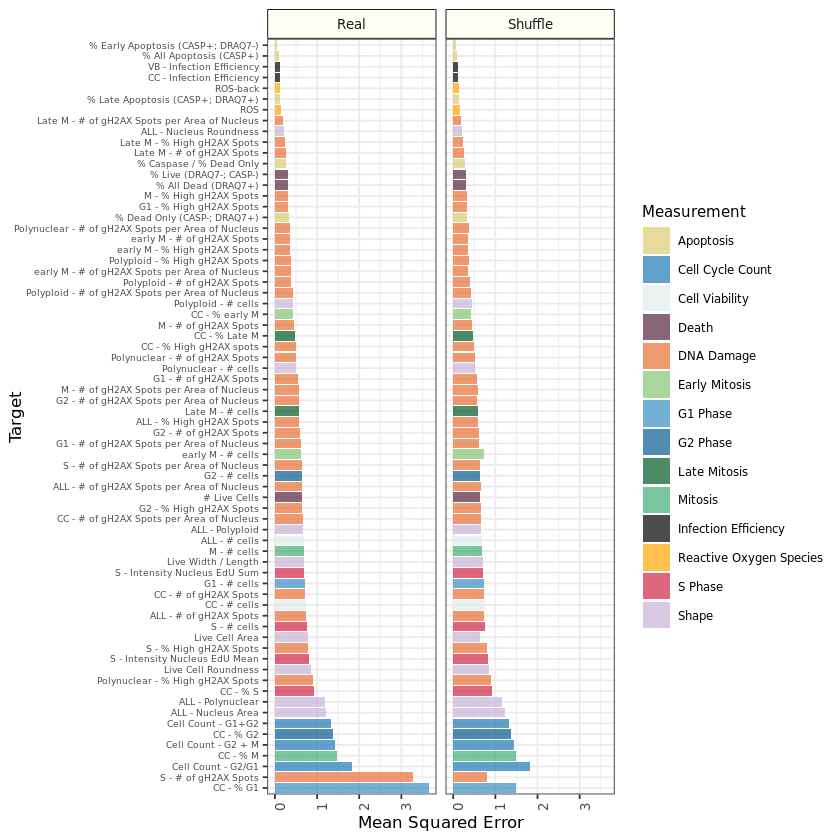

In [38]:
ggplot(mse_df,
       aes(x = readable_name,
           y = value)) +
    geom_bar(aes(fill = measurement),
             stat = "identity",
             alpha = 0.7,
             position = position_dodge()) +
    facet_grid(~shuffle, scales="free_y") +
    coord_flip() +
    theme_bw() +
    ylab("Mean Squared Error") +
    xlab("Target") +
    scale_fill_manual(name = "Measurement",
                      values = measurement_colors,
                      labels = measurement_labels) +
    theme(axis.text.x = element_text(size = 8, angle = 90),
          axis.text.y = element_text(size = 5.5),
          axis.title = element_text(size = 10),
          legend.position = "right",
          legend.text = element_text(size = 7),
          legend.title = element_text(size = 9),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

file <- file.path(
    figure_dir,
    paste0("mse_test_summary_", consensus, ".png")
)

ggsave(file, dpi = 500, width = 7, height = 6)

In [39]:
# Split shuffle column for scatter plot
mse_spread_df <- mse_df %>% tidyr::spread(shuffle, value)

head(mse_spread_df, 2)

metric,target,data_type,y_transform,cell_line,readable_name,original_name,feature_type,measurement,gate_required,...,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description,Real,Shuffle
mse,cc_all_high_h2ax,Test,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,...,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,0.58,0.58
mse,cc_all_large_notround_polynuclear_mean,Test,raw,all,ALL - Polynuclear,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,shape,1,...,0,0,0,0,0,0,0,Fraction of cells with large non-round nuclei (Polynuclear),1.18,1.15


Warning message:
“Removed 20 rows containing missing values (geom_point).”
Warning message:
“Removed 20 rows containing missing values (geom_point).”


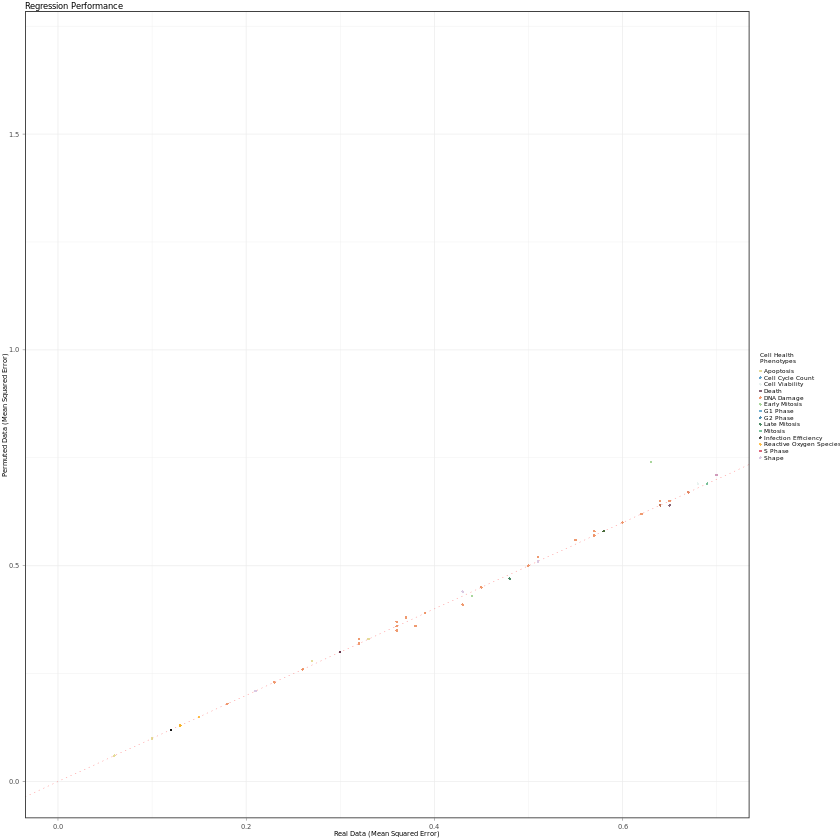

In [40]:
ggplot(mse_spread_df,
       aes(x = Real,
           y = Shuffle,
           color = measurement)) +
    geom_abline(intercept = 0,
                lwd = 0.1,
                slope = 1,
                linetype = "dotted",
                alpha = 0.7,
                color = "red") +
    geom_point(size = 0.4,
               alpha = 0.7,
               pch = 16) +
    xlim(c(0, 0.7)) +
    ylim(c(0, 1.7)) +
    xlab("Real Data (Mean Squared Error)") +
    ylab("Permuted Data (Mean Squared Error)") +
    ggtitle("Regression Performance") +
    theme_bw() +
    dye_theme +
    scale_color_manual(
        name = "Cell Health\nPhenotypes",
        values = measurement_colors,
        labels = measurement_labels
    )

output_file <- file.path(
    figure_dir
    ,
    paste0("mse_comparison_scatter_", consensus, ".png")
)
ggsave(output_file, width = 2, height = 1.5, dpi = 500, units = "in")

### Visualize R^2 Performance

In [41]:
r2_df <- regression_metrics_df %>%
    dplyr::filter(metric == "r_two",
                  y_transform == "raw") %>%
    dplyr::left_join(label_df, by = c("target" = "id"))

# Sort mse by r2 in test set
target_order <- r2_df %>%
    dplyr::filter(data_type == "Test",
                  shuffle == "Real") %>%
    dplyr::arrange(value) %>%
    dplyr::select(readable_name)

r2_df$readable_name <- factor(r2_df$readable_name, levels=target_order$readable_name)

# Recode metadata measurent to other
r2_df$measurement <- dplyr::recode(r2_df$measurement, "metadata" = "other")

r2_df$measurement <- factor(r2_df$measurement, levels = c(
    "cell_viability",
    "death",
    "apoptosis",
    "ros",
    "dna_damage",
    "g1_phase",
    "s_phase",
    "g2_phase",
    "early_mitosis",
    "mitosis",
    "late_mitosis",
    "cell_cycle_count",
    "shape",
    "other"
))

head(r2_df, 4)

value,metric,target,data_type,shuffle,y_transform,cell_line,readable_name,original_name,feature_type,...,assay,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description
0.03,r_two,cc_all_high_h2ax,Train,Shuffle,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,...,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots
0.00,r_two,cc_all_high_h2ax,Test,Shuffle,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,...,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots
0.01,r_two,cc_all_high_h2ax,Train,Real,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,...,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots
0.00,r_two,cc_all_high_h2ax,Test,Real,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,...,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots


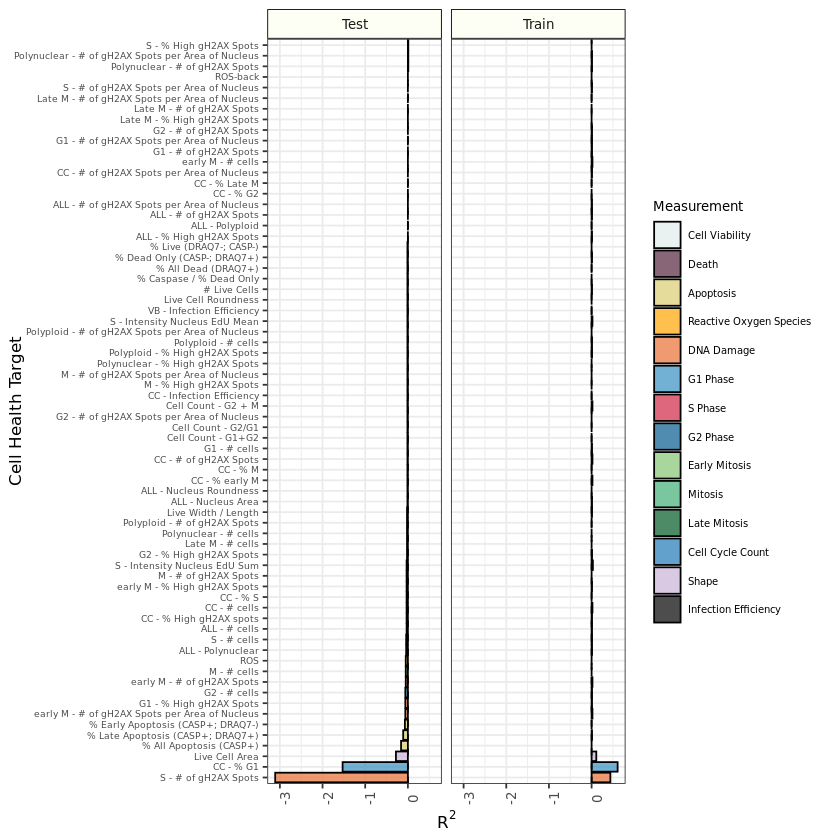

In [42]:
rsquared_bar_gg <- ggplot(r2_df %>% dplyr::filter(shuffle == "Real"),
       aes(x = readable_name,
           y = value)) +
    geom_bar(aes(fill = measurement),
             stat = "identity",
             alpha = 0.7,
             color = "black",
             position = position_dodge()) +
    facet_grid(~data_type, scales = "free_y") +
    coord_flip() +
    theme_bw() +
    geom_hline(yintercept = 0, linetype = "dashed") +
    ylab(bquote(R^2)) +
    xlab("Cell Health Target") +
    scale_fill_manual(name = "Measurement",
                      values = measurement_colors,
                      labels = measurement_labels) +
    theme(axis.text.x = element_text(size = 8, angle = 90),
          axis.text.y = element_text(size = 5.5),
          axis.title = element_text(size = 10),
          legend.position = "right",
          legend.text = element_text(size = 6),
          legend.title = element_text(size = 8),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

file <- file.path(
    figure_dir,
    paste0("r_squared_model_summary_", consensus, ".png")
)
ggsave(file, rsquared_bar_gg, dpi = 500, width = 7, height = 6)

rsquared_bar_gg

In [43]:
# Process data for cell line specific plot
cellline_compare_regression_df <- all_regression_metrics_df %>%
    dplyr::filter(cell_line != "all",
                  data_type == "Test",
                  metric == "r_two",
                  shuffle == "Real") %>%
    dplyr::mutate(outlier = ifelse(value < 0, "R2: < 0", "R2: 0 to 1")) %>%
    dplyr::left_join(label_df, by = c("target" = "id"))

cellline_compare_regression_df$measurement <-
    dplyr::recode(cellline_compare_regression_df$measurement, "metadata" = "other")

cellline_compare_regression_df$readable_name <- factor(
    cellline_compare_regression_df$readable_name,
    levels=target_order$readable_name
)

head(cellline_compare_regression_df, 2)

value,metric,target,data_type,shuffle,y_transform,cell_line,outlier,readable_name,original_name,...,assay,hoechst,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description
-0.01,r_two,cc_all_high_h2ax,Test,Real,raw,A549,R2: < 0,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,...,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots
-0.03,r_two,cc_all_high_h2ax,Test,Real,raw,ES2,R2: < 0,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,...,hoechst_gh2ax,1,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots


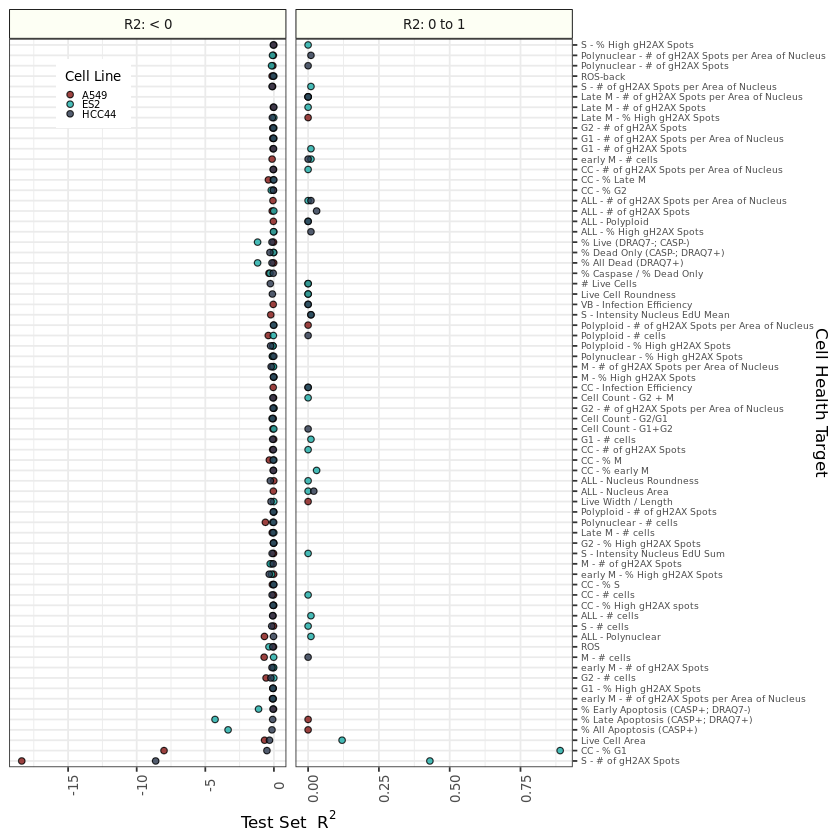

In [44]:
rsquared_bar_cellline_gg <- ggplot(cellline_compare_regression_df,
                                   aes(x = value, y = readable_name, fill = cell_line)) +
    geom_point(alpha = 0.8, shape = 21, color = "black") +
    theme_bw() +
    xlab(bquote("Test Set "~R^2~"")) +
    ylab("Cell Health Target") +
    facet_wrap(~outlier, scales="free_x") +
    scale_fill_manual(
        name = "Cell Line",
        labels = cell_line_labels,
        values = cell_line_colors
    ) +
    scale_y_discrete(position = "right") +
    theme(axis.text.x = element_text(size = 8, angle = 90),
          axis.text.y = element_text(size = 5.5),
          axis.title = element_text(size = 10),
          legend.position = c(0.15, 0.925),
          legend.text = element_text(size = 6),
          legend.title = element_text(size = 8),
          legend.key = element_rect(size = 4),
          legend.key.size = unit(0.4, 'lines'),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("cell_line_differences_rsquared_", consensus, ".png")
)
ggsave(output_file, rsquared_bar_cellline_gg, dpi = 500, width = 7, height = 6)
rsquared_bar_cellline_gg

In [45]:
regression_legend <- cowplot::get_legend(rsquared_bar_gg)

In [46]:
left_panel_margin <- margin(l = -0.8, r = 0.5, t = 0.2, b = 0.2, unit = "cm")
right_panel_margin <- margin(l = 0, r = -0.8, t = 0.2, b = 0.2, unit = "cm")

regression_performance_figure <- cowplot::plot_grid(
    rsquared_bar_gg +
        theme(legend.position = 'none',
              plot.margin = left_panel_margin) + xlab(""),
    regression_legend,
    rsquared_bar_cellline_gg +
        theme(plot.margin = right_panel_margin) + ylab(""),
    labels = c("a", "", "b"),
    ncol = 3,
    nrow = 1,
    align = "h",
    hjust = c(-0.5, -0.5, 3),
    rel_widths = c(1, 0.3, 1)
)

output_file <- file.path(
    figure_dir,
    paste0("regression_performance_figure_", consensus, ".png")
)
cowplot::save_plot(output_file, regression_performance_figure, base_width = 10, base_height = 6)

Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


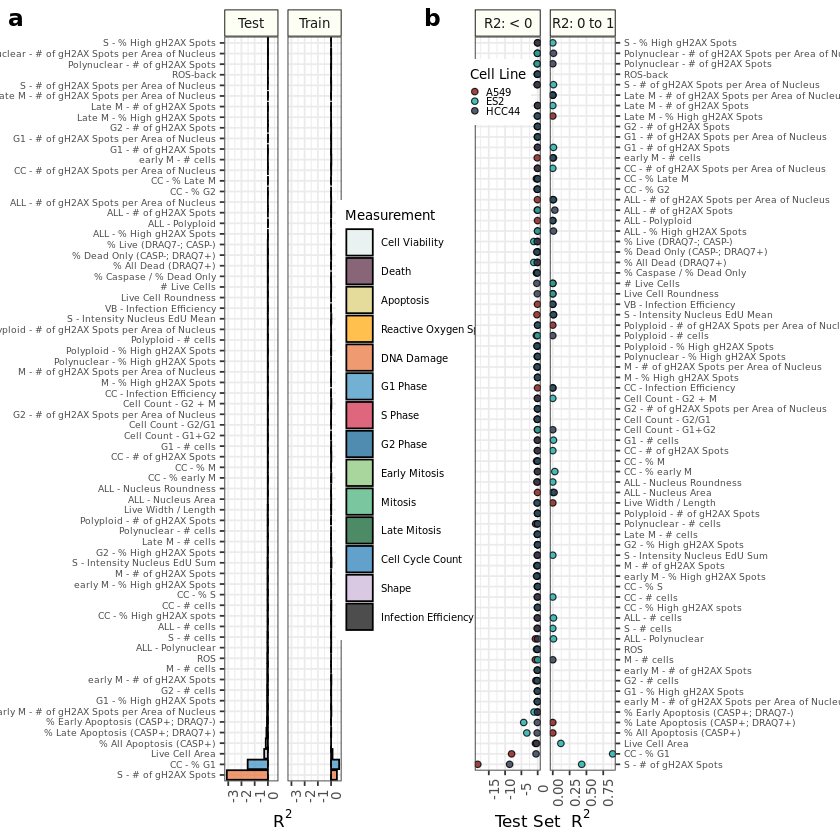

In [47]:
regression_performance_figure

## Generate a More Concise Summary Figure

In [48]:
concise_fig_df <- r2_df %>%
    dplyr::filter(shuffle == "Real", data_type == "Test") %>%
    dplyr::select(value, metric, target, data_type, shuffle, y_transform, cell_line, readable_name, measurement)

concise_fig_df$data_fit <- dplyr::recode(
    concise_fig_df$data_type,
    "Test" = "Test Set Performance\n(Data not used in training)"
)

head(concise_fig_df, 2)

value,metric,target,data_type,shuffle,y_transform,cell_line,readable_name,measurement,data_fit
0.00,r_two,cc_all_high_h2ax,Test,Real,raw,all,ALL - % High gH2AX Spots,dna_damage,Test Set Performance (Data not used in training)
-0.04,r_two,cc_all_large_notround_polynuclear_mean,Test,Real,raw,all,ALL - Polynuclear,shape,Test Set Performance (Data not used in training)


In [49]:
cell_line_focus_df <- cellline_compare_regression_df %>%
    dplyr::select(value, metric, target, data_type, shuffle, y_transform, cell_line, readable_name, measurement) %>%
    dplyr::distinct() %>%
    dplyr::mutate(truncated_value = ifelse(value < -1, -1, value))

cell_line_focus_df$data_fit <- dplyr::recode(
    cell_line_focus_df$data_type,
    "Test" = "Test Set Performance\n(Data not used in training)"
)

head(cell_line_focus_df, 2)

value,metric,target,data_type,shuffle,y_transform,cell_line,readable_name,measurement,truncated_value,data_fit
-0.01,r_two,cc_all_high_h2ax,Test,Real,raw,A549,ALL - % High gH2AX Spots,dna_damage,-0.01,Test Set Performance (Data not used in training)
-0.03,r_two,cc_all_high_h2ax,Test,Real,raw,ES2,ALL - % High gH2AX Spots,dna_damage,-0.03,Test Set Performance (Data not used in training)


In [50]:
measurement_legend <- cowplot::get_legend(
    ggplot(concise_fig_df,
       aes(x = readable_name)) +
    geom_bar(aes(fill = measurement, y = value),
             stat = "identity",
             alpha = 0.7,
             position = position_dodge()) +
    facet_grid(~data_fit, scales = "free_y") +
    theme_bw() +
    coord_flip() +
    geom_hline(yintercept = 0, linetype = "dashed") +
    ylab(bquote(R^2)) +
    xlab("Cell Health Target") +
    scale_fill_manual(name = "Measurement",
                      values = measurement_colors,
                      labels = measurement_labels) +
    theme(axis.text.x = element_text(size = 9, angle = 90),
          axis.text.y = element_text(size = 6),
          axis.title = element_text(size = 10),
          legend.position = "right",
          legend.text = element_text(size = 7),
          legend.title = element_text(size = 9),
          strip.text = element_text(size = 9),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))
)

cell_line_legend <- cowplot::get_legend(
    ggplot(concise_fig_df,
       aes(x = readable_name)) +
    geom_point(data = cell_line_focus_df, aes(shape = cell_line, y = truncated_value, fill = measurement)) +
    facet_grid(~data_fit, scales = "free_y") +
    theme_bw() +
    coord_flip() +
    geom_hline(yintercept = 0, linetype = "dashed") +
    ylab(bquote(R^2)) +
    xlab("Cell Health Target") +
    scale_fill_manual(name = "Measurement",
                      values = measurement_colors,
                      labels = measurement_labels) +
    scale_shape_manual(name = "Cell Line",
                       values = c("A549" = 21, "ES2" = 24, "HCC44" = 22),
                       labels = c("A549" = "A549", "ES2" = "ES2", "HCC44" = "HCC44")) +
    theme(axis.text.x = element_text(size = 9, angle = 90),
          axis.text.y = element_text(size = 6),
          axis.title = element_text(size = 10),
          legend.position = "right",
          legend.text = element_text(size = 7),
          legend.title = element_text(size = 9),
          strip.text = element_text(size = 9),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")) +
    guides(fill = FALSE,
           shape = guide_legend(order = 1))
)

concise_legend_gg <- cowplot::plot_grid(
    cell_line_legend,
    cowplot::ggdraw(),
    measurement_legend,
    cowplot::ggdraw(),
    nrow = 4,
    align = "v",
    axis = "l",
    rel_heights = c(1, 0.3, 1, 0.7)
)

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '≤ -1.0' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '≤ -1.0' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '≤ -1.0' in 'mbcsToSbcs': dot substituted for <a4>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '≤ -1.0' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '≤ -1.0' in 'mbcsToSbcs': dot substituted for <89>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '≤ -1.0' in 'mbcsToSbcs': dot substitu

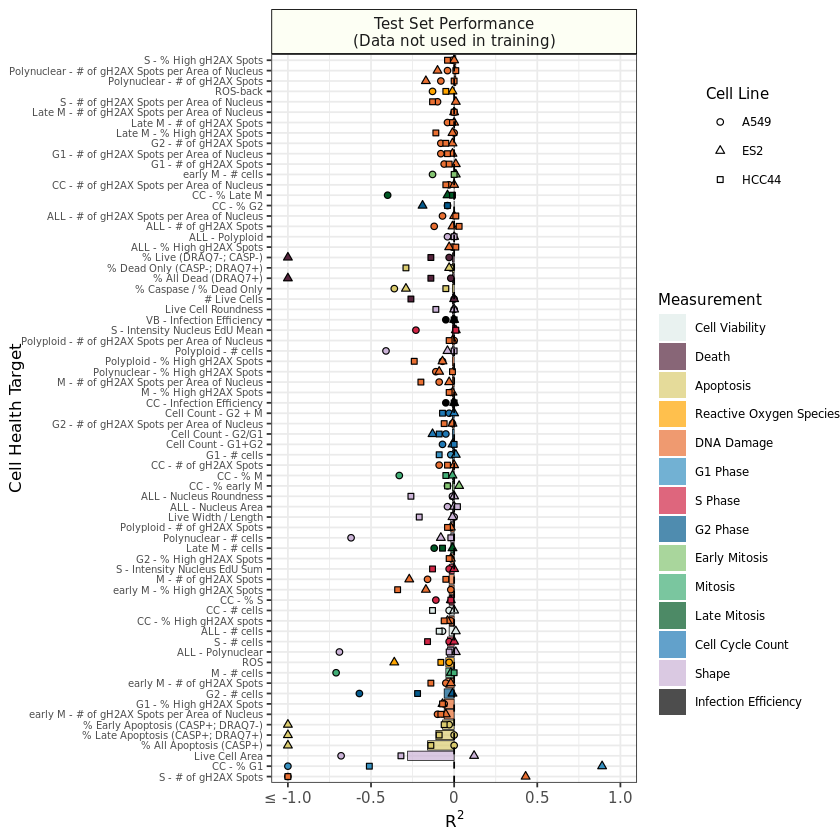

In [51]:
concise_gg <- ggplot(concise_fig_df,
       aes(x = readable_name)) +
    geom_bar(aes(fill = measurement, y = value),
             stat = "identity",
             alpha = 0.7,
             color = "black",
             lwd = 0.2,
             position = position_dodge()) +
    geom_point(data = cell_line_focus_df, aes(shape = cell_line, y = truncated_value, fill = measurement)) +
    facet_grid(~data_fit, scales = "free_y") +
    theme_bw() +
    coord_flip() +
    geom_hline(yintercept = 0, linetype = "dashed") +
    ylab(bquote(R^2)) +
    xlab("Cell Health Target") +
    scale_fill_manual(name = "Measurement",
                      values = measurement_colors,
                      labels = measurement_labels) +
    scale_shape_manual(name = "Cell Line",
                       values = c("A549" = 21, "ES2" = 24, "HCC44" = 22),
                       labels = c("A549" = "A549", "ES2" = "ES2", "HCC44" = "HCC44")) +
    theme(axis.text.x = element_text(size = 9),
          axis.text.y = element_text(size = 6),
          axis.title = element_text(size = 10),
          legend.position = "none",
          strip.text = element_text(size = 9),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")) +
    scale_y_continuous(
        limits = c(-1, 1),
        breaks = c(-1.0, -0.5, 0, 0.5, 1.0),
        labels = c("\u2264 -1.0", "-0.5", "0", "0.5", "1.0")
        )

output_file <- file.path(
    figure_dir,
    paste0("concise_regression_summary_", consensus, ".png")
)

concise_gg_full <- cowplot::plot_grid(
    concise_gg,
    concise_legend_gg,
    ncol = 2,
    rel_widths = c(1, 0.3)
)

cowplot::save_plot(output_file, concise_gg_full, dpi = 600, base_width = 7, base_height = 6)

concise_gg_full

## More Summary Figures

In [52]:
# Split shuffle column for scatter plot
r2_spread_df <- r2_df %>% tidyr::spread(shuffle, value)
r2_spread_df$data_type <- factor(r2_spread_df$data_type, levels = c("Train", "Test"))

head(r2_spread_df, 2)

metric,target,data_type,y_transform,cell_line,readable_name,original_name,feature_type,measurement,gate_required,...,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description,Real,Shuffle
r_two,cc_all_high_h2ax,Train,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,...,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,0.01,0.03
r_two,cc_all_high_h2ax,Test,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,...,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,0.00,0.00


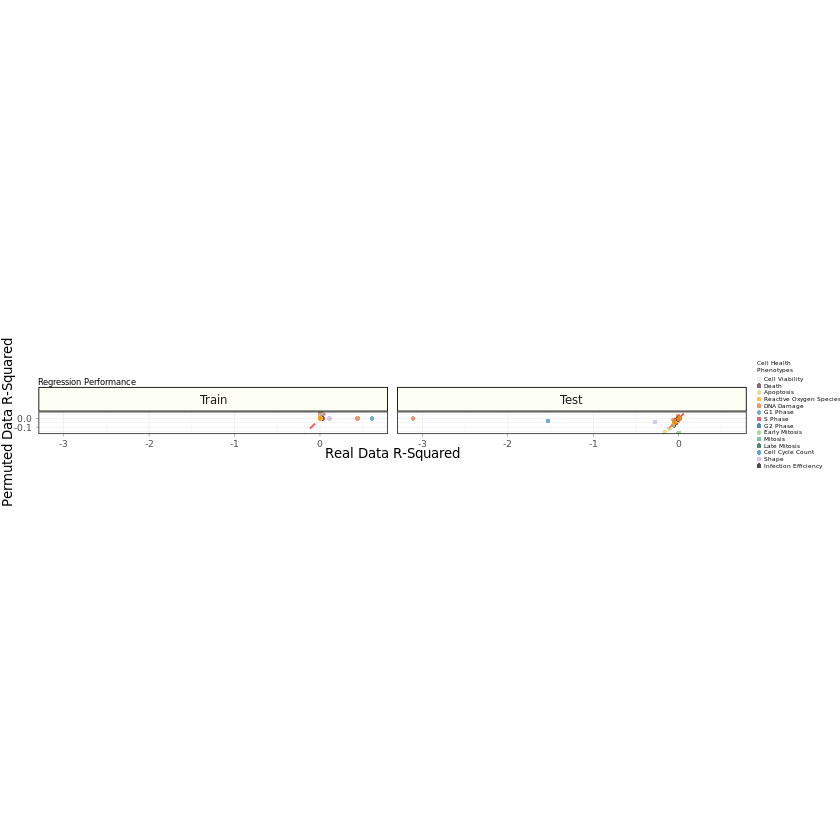

In [53]:
ggplot(r2_spread_df,
       aes(x = Real,
           y = Shuffle,
           color = measurement)) +
    geom_abline(intercept = 0,
                lwd = 0.5,
                slope = 1,
                linetype = "dashed",
                alpha = 0.7,
                color = "red") +
    geom_point(size = 1,
               alpha = 0.7,
               pch = 16) +
    xlab("Real Data R-Squared") +
    ylab("Permuted Data R-Squared") +
    ggtitle("Regression Performance") +
    theme_bw() +
    facet_wrap("~data_type") +
    coord_fixed() +
    scale_color_manual(
        name = "Cell Health\nPhenotypes",
        values = measurement_colors,
        labels = measurement_labels
    ) +
    dye_theme +
    theme(axis.text.x = element_text(size = 5.5),
          axis.text.y = element_text(size = 5.5),
          axis.title = element_text(size = 8),
          strip.text = element_text(size = 7),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path(
    figure_dir,
    paste0("r_squared_comparison_scatter_", consensus, ".png")
)
ggsave(output_file, width = 5.5, height = 3, dpi = 600, units = "in")

## Generate Plot for a Subset of Models

These models span the range of performance.
The figure will be used as a supplementary figure in the cell health manuscript.

In [54]:
good_example_models <- c(
    "vb_percent_dead",
    "cc_s_n_objects",
    "cc_g1_n_spots_h2ax_mean",
    "vb_percent_all_apoptosis"
)

bad_example_models <- c(
    "cc_polynuclear_n_spots_h2ax_mean",
    "cc_cc_late_mitosis"
)

In [55]:
plot_list <- list()
for (good_model in c(good_example_models, bad_example_models)) {
    
    sup_fig_good_subset_df <- y_plot_df %>%
        dplyr::filter(
            target == !!good_model,
            y_transform == "raw"
        )
    sup_fig_good_subset_df$shuffle <- sup_fig_good_subset_df$shuffle %>%
        dplyr::recode_factor(
            "shuffle_false" = "Real",
            "shuffle_true" = "Permuted"
        )
    
    r2_df <- regression_metrics_df %>%
    dplyr::filter(
        metric == "r_two",
        target == !!good_model,
        y_transform == "raw"
    ) %>%
    dplyr::rename(r2 = value) %>%
    dplyr::mutate(x = max(sup_fig_good_subset_df$recode_target_value_true) -
                  sd(sup_fig_good_subset_df$recode_target_value_true) * 3,
                  y = max(sup_fig_good_subset_df$recode_target_value_pred) -
                  sd(sup_fig_good_subset_df$recode_target_value_true) * 2.5)

    r2_df$shuffle <- r2_df$shuffle %>%
            dplyr::recode_factor(
                "Shuffle" = "Permuted"
            )
    
    readable_title <- label_df %>%
        dplyr::filter(id == !!good_model) %>%
        dplyr::pull(readable_name)
    
    plot_list[[good_model]] <- ggplot(sup_fig_good_subset_df,
           aes(x = recode_target_value_true,
               y = recode_target_value_pred)) +
        geom_smooth(method = 'lm', formula = y~x) +
        geom_point(aes(color = Metadata_cell_line),
                   size = 0.5,
                   alpha = 0.5) +
        facet_grid(data_type~shuffle) +
        ggtitle(readable_title) +
        theme_bw() +
        xlab("True Values") +
        ylab("Predicted Values") +
        scale_color_manual(
            name = "Cell Line",
            labels = cell_line_labels,
            values = cell_line_colors
        ) +
        geom_rect(data = sup_fig_good_subset_df %>%
                    dplyr::filter(data_type == "Test", shuffle == "Real") %>%
                    dplyr::distinct(data_type, shuffle, .keep_all = TRUE), 
                  fill = NA, alpha = 1, colour = "red", linetype = "solid", size = 2,
                  xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf) +
        geom_text(data = r2_df, size = 3, aes(label = paste("R2 =", r2), x = x, y = y)) +
        theme(strip.text = element_text(size = 10),
              strip.background = element_rect(colour = "black",
                                              fill = "#fdfff4"))
}

Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


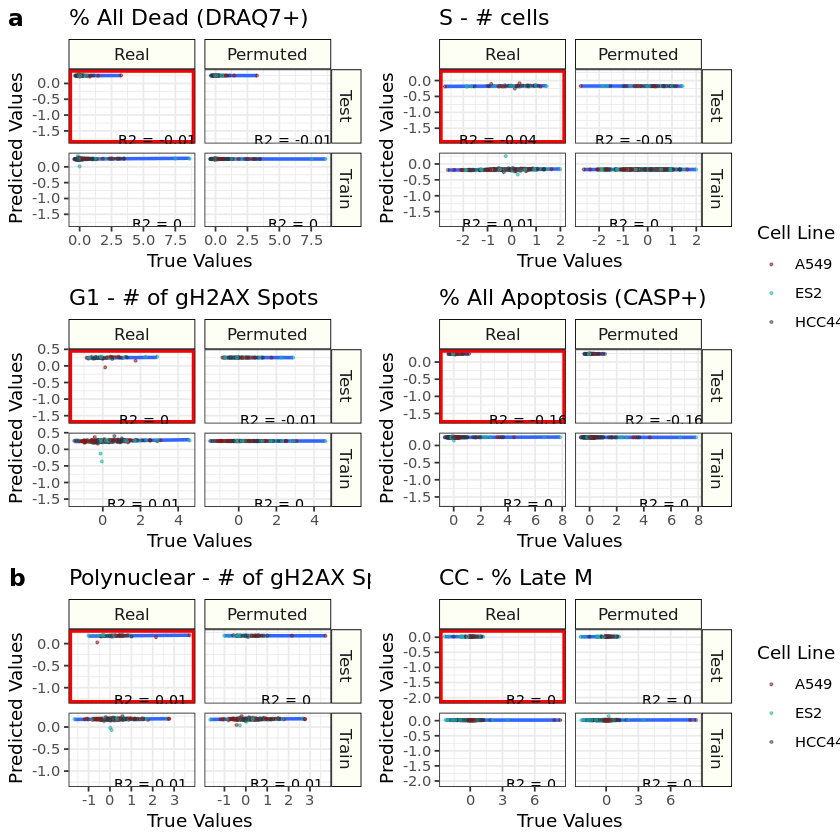

In [56]:
# Compile and save figure
cell_line_legend <- get_legend(
  plot_list[["vb_percent_dead"]] + theme(legend.box.margin = margin(0, 0, 0, 12))
)

top_row_gg <- cowplot::plot_grid(
    plot_list[["vb_percent_dead"]] + theme(legend.position = "none"),
    plot_list[["cc_s_n_objects"]] + theme(legend.position = "none"),
    nrow = 1,
    align = "h"
)

middle_row_gg <- cowplot::plot_grid(
    plot_list[["cc_g1_n_spots_h2ax_mean"]] + theme(legend.position = "none"),
    plot_list[["vb_percent_all_apoptosis"]] + theme(legend.position = "none"),
    nrow = 1,
    align = "h"
)

sup_fig_part_a <- cowplot::plot_grid(
    top_row_gg,
    middle_row_gg,
    nrow = 2,
    align = "h"
)

sup_fig_part_a <- cowplot::plot_grid(
    sup_fig_part_a,
    cell_line_legend,
    rel_widths = c(3, 0.4),
    ncol = 2
)

bottom_row_gg <- cowplot::plot_grid(
    plot_list[["cc_polynuclear_n_spots_h2ax_mean"]] + theme(legend.position = "none"),
    plot_list[["cc_cc_late_mitosis"]] + theme(legend.position = "none"),
    nrow = 1,
    align = "h"
)

sup_fig_part_b <- cowplot::plot_grid(
    bottom_row_gg,
    cell_line_legend,
    rel_widths = c(3, 0.4),
    ncol = 2,
    align = "v"
)

sup_fig_full <- cowplot::plot_grid(
    sup_fig_part_a,
    sup_fig_part_b,
    rel_heights = c(4, 2),
    nrow = 2,
    labels = c("a", "b"),
    align = "v"
)

sup_fig_full

In [57]:
 # Save figure
supfig_file <- file.path(figure_dir, "supplementary_figure_example_distributions.png")

cowplot::save_plot(
    filename = supfig_file,
    plot = sup_fig_full,
    base_height = 8,
    base_width = 8,
    dpi = 600
)

## Plot performance metrics for each target variable

In [58]:
label_thresh_value = 0.925

pdf_file <- file.path(
    figure_dir,
    paste0("all_regression_performance_metrics_", consensus, ".pdf")
)
pdf(pdf_file, width = 6, height = 8, onefile = TRUE)

for (target in unique(y_plot_df$target)) {
    # Subset all dataframes
    y_subset_df <- y_plot_df %>% dplyr::filter(target == !!target)
    
    y_subset_df$shuffle <- y_subset_df$shuffle %>%
        dplyr::recode_factor("shuffle_false" = "Real",
                             "shuffle_true" = "Permuted")
    
    coef_subset_df <- full_coef_df %>%
        dplyr::filter(target == !!target)
    metrics_subset_df <- regression_metrics_df %>%
        dplyr::filter(target == !!target)
    
    for (y_transform in unique(y_subset_df$y_transform)) {
        y_subset_transform_df <- y_subset_df %>%
            dplyr::filter(y_transform == !!y_transform)
        
        coef_subset_transform_df <- coef_subset_df %>%
            dplyr::filter(y_transform == !!y_transform,
                          shuffle == "shuffle_false") %>%
            dplyr::mutate(weight_rank = row_number(weight))
        
        metrics_subset_transform_df <- metrics_subset_df %>%
            dplyr::filter(y_transform == !!y_transform)
        
        pred_scatter_gg <-
           ggplot(y_subset_transform_df,
                  aes(x = recode_target_value_true,
                      y = recode_target_value_pred)) +
                geom_point(aes(color = Metadata_cell_line),
                           size = 0.5, alpha = 0.8) +
                facet_grid(data_type~shuffle) +
                theme_bw() +
                xlab("True Values") +
                ylab("Predicted Values") +
                scale_color_manual(
                    name = "Cell Line",
                    labels = cell_line_labels,
                    values = cell_line_colors
                ) +
                geom_smooth(method='lm', formula=y~x) +
                theme(strip.text = element_text(size = 10),
                      strip.background = element_rect(colour = "black",
                                                      fill = "#fdfff4"))
        
        # Setup labeling thresholds
        non_zero_coef <- coef_subset_transform_df$abs_weight[coef_subset_transform_df$abs_weight > 0]
        label_thresh <- quantile(non_zero_coef, label_thresh_value)
        label_logic <- coef_subset_transform_df$abs_weight > label_thresh

        coef_gg <-
            ggplot(coef_subset_transform_df,
                   aes(x = weight_rank,
                       y = weight)) +
                geom_point(size = 0.2,
                           alpha = 0.6) +
                xlab("Weight Rank") +
                ylab("Weight") +
                geom_text_repel(
                    data = subset(coef_subset_transform_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.4,
                    point.padding = 0.1,
                    segment.size = 0.5,
                    segment.alpha = 0.6,
                    size = 1.5,
                    fontface = "italic",
                    aes(label = feature,
                        x = weight_rank,
                        y = weight)) +
                theme_bw()
        
         # Build table for plotting performance metrics
        mse_df <- metrics_subset_transform_df %>%
            dplyr::filter(metric == "mse") %>%
            dplyr::select(-metric)
        mse_df$value = abs(mse_df$value)

        r2_df <- metrics_subset_transform_df %>%
            dplyr::filter(metric == "r_two") %>%
            dplyr::rename(r2 = value) %>%
            dplyr::select(-metric)

        metric_table_df <- r2_df %>%
            dplyr::inner_join(mse_df,
                              by=c("target", "data_type", "shuffle", "y_transform")) %>%
            dplyr::select(data_type, shuffle, y_transform, r2, value) %>%
            dplyr::rename(fit = data_type, transform = y_transform) %>%
            dplyr::arrange(shuffle)

        metric_table_df$shuffle <- dplyr::recode(
            metric_table_df$shuffle,
            shuffle_true = "True",
            shuffle_false = "False"
        )

        # Plot all performance metrics together with cowplot
        table_theme <- gridExtra::ttheme_default(
            core = list(fg_params=list(cex = 0.7)),
            colhead = list(fg_params=list(cex = 0.8))
        )

        table_gg <- gridExtra::tableGrob(metric_table_df,
                                         theme = table_theme,
                                         rows = NULL)
        
        bottom_row_gg <- cowplot::plot_grid(
            table_gg,
            coef_gg,
            rel_widths = c(0.8, 1),
            nrow = 1
        )
        regression_perf_gg <- cowplot::plot_grid(
            pred_scatter_gg,
            bottom_row_gg,
            rel_heights = c(1, 0.8),
            nrow = 2
        )
        
        target_title <- cowplot::ggdraw() + 
          cowplot::draw_label(
            paste("Performance:", target, "\nTransform:", y_transform),
            fontface = 'bold',
            x = 0,
            hjust = 0
          ) +
          theme(
            plot.margin = margin(0, 0, 0, 7)
          )

        regression_perf_gg <- cowplot::plot_grid(
            target_title,
            regression_perf_gg,
            ncol = 1,
            rel_heights = c(0.1, 1)
        )
        
        # Save figure
        cowplot_file <- file.path(
            individual_fig_dir,
            paste0(target, "_", y_transform, "_performance_", consensus, ".png")
        )

        cowplot::save_plot(
            filename = cowplot_file,
            plot = regression_perf_gg,
            base_height = 6,
            base_width = 6
        )
        
        print(regression_perf_gg)
    }
}

dev.off()

Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2